In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tabulate
from scipy import stats
from autorank import autorank,create_report,plot_stats
pd.set_option("chained_assignment", None)
pd.set_option("display.max_rows", 5000)
pd.set_option("display.max_columns", 5000)
pd.set_option("display.width", 10000)

def load_priorband_data():
    df = pd.read_parquet("data_for_anton.parquet")
    df=df.reset_index()
    df_collection=[]
    for seed_nr in range(50):
        partial_df=df[["benchmark","prior","algorithm","used_fidelity"]]
        partial_df["value"]=df[f"seed-{seed_nr}"]
        partial_df["seed"]=seed_nr
        df_collection.append(partial_df)
        print(f"Seed {seed_nr+1}/50", end="\r", flush=True)
    df_complete=pd.concat(df_collection,ignore_index=True)
    df_complete[["value","used_fidelity"]]=df_complete[["value","used_fidelity"]].astype(float)
    return df_complete

df=load_priorband_data()

In [2]:

algo_dict={"rs_hb_pb":["random_search","hyperband","pb_mutation_dynamic_geometric-default-at-target"]}
#algo_dict["fig7"]=["random_search_prior","bo","bohb","priorband_bo"]
prior_dict={"good+bad":["at25","bad"]}
benchmarks=["jahs_cifar10","jahs_colorectal_histology","jahs_fashion_mnist","lcbench-126026","lcbench-167190","lcbench-168330","lcbench-168910","lcbench-189906","cifar100_wideresnet_2048","imagenet_resnet_512","lm1b_transformer_2048","translatewmt_xformer_64"]
label_dict={'random_search': 'RS', 'hyperband': 'HB', 'pb_mutation_dynamic_geometric-default-at-target': 'PB', 'jahs_cifar10': 'JAHS-C10', 'jahs_colorectal_histology': 'JAHS-CH', 'jahs_fashion_mnist': 'JAHS-FM', 'lcbench-126026': 'LC-126026', 'lcbench-167190': 'LC-167190', 'lcbench-168330': 'LC-168330', 'lcbench-168910': 'LC-168910', 'lcbench-189906': 'LC-189906', 'cifar100_wideresnet_2048': 'PD1-Cifar100', 'imagenet_resnet_512': 'PD1-ImageNet', 'lm1b_transformer_2048': 'PD1-LM1B', 'translatewmt_xformer_64': 'PD1-WMT',"random_search_prior":"RS+Prior","bo":"BO","pibo":"PiBO","bohb":"BOHB","priorband_bo":"PriorBand+BO"}


for priortype in df["prior"].unique():
    prior_dict[priortype]=[priortype]


df_dict={}
for prior_key,prior_value in prior_dict.items():
    df_dict[prior_key]={}
    for b_n,benchmark in enumerate(benchmarks):
        print(f"Prior {prior_key}, Benchmark {b_n+1}/{len(benchmarks)}      ", end="\r", flush=True)
        df_dict[prior_key][benchmark]={}
        for algo_key,algo_value in algo_dict.items():
            df_dict[prior_key][benchmark][algo_key]=df.loc[(df["prior"].isin(prior_value))&(df["algorithm"].isin(algo_value))&(df["benchmark"]==benchmark)].reset_index(drop=True)

In [3]:
def create_lmem_incumbent(priors:list[str],fs,algorithms:list[str],algo_group:str,benchmarks:list[str],df_dict:pd.DataFrame):
    output={}
    output["dataset"]={}
    output["mean_std"]={}
    for p_n,prior in enumerate(priors):
        output["dataset"][prior]={}
        output["mean_std"][prior]={}
        for n_f,max_f in enumerate(fs):
            output["dataset"][prior][max_f]={}
            labels=[]
            for n_a,algo in enumerate(algorithms):
                labels.append(label_dict[algo])
            output["mean_std"][prior][max_f]=pd.DataFrame(columns=["benchmark"]+labels)
            output["dataset"][prior][max_f]=pd.DataFrame()
            for benchmark in benchmarks:
                df_at_point=df_dict[prior][benchmark][algo_group]
                df_at_point=df_at_point.loc[df_at_point["used_fidelity"]<=max_f]
                for seed in df_at_point["seed"].unique():
                    print(f"Prior {prior} ({p_n+1}), Fidelity {n_f+1}/{len(fs)}, Algorithm {n_a}/{len(algorithms)}          ", end="\r", flush=True)
                    for algo in algorithms:
                        output["dataset"][prior][max_f]=pd.concat([output["dataset"][prior][max_f],df_at_point.loc[(df_at_point["seed"]==seed)&(df_at_point["algorithm"]==algo)].iloc[-1].to_frame().T],ignore_index=True)
            output["dataset"][prior][max_f][["value","used_fidelity"]]=output["dataset"][prior][max_f][["value","used_fidelity"]].astype(float)
            output["dataset"][prior][max_f][["seed"]]=output["dataset"][prior][max_f][["seed"]].astype(int)
            output["dataset"][prior][max_f][["seed"]]=max_f
    return output["dataset"]


In [4]:
from significance_analysis import conduct_analysis

fig5={}
fig5["algo_group"]="rs_hb_pb"
fig5["algorithms"]=algo_dict[fig5["algo_group"]].copy()
fig5["priors"]=["good+bad","at25","bad"]
fig5["benchmarks"]=benchmarks
fig5["max_f"]=np.linspace(1,12,50).tolist()

fig5["dataset"]=create_lmem_incumbent(fig5["priors"],fig5["max_f"],fig5["algorithms"],fig5["algo_group"],fig5["benchmarks"],df_dict)

In [5]:
result_dict={}
for p_n,priortype in enumerate(fig5["priors"]):
    result_dict[priortype]={}
    for f_n,max_f in enumerate(fig5["max_f"]):
        print(f"Prior {priortype} ({p_n+1}), Fidelity {f_n+1}/{len(fig5['max_f'])}          ", end="\r", flush=True)
        fig5["dataset"][priortype][max_f]=fig5["dataset"][priortype][max_f].replace({"algorithm": label_dict,"benchmark": label_dict})
        result_dict[priortype][max_f]=conduct_analysis(fig5["dataset"][priortype][max_f],"value","algorithm","benchmark",continuous_fidelity=False,show_plots=False,verbosity=0)[1]


P-values adjusted by tukey method for family of 3 estimates
P-values adjusted by tukey method for family of 3 estimates
P-values adjusted by tukey method for family of 3 estimates
P-values adjusted by tukey method for family of 3 estimates
P-values adjusted by tukey method for family of 3 estimates
P-values adjusted by tukey method for family of 3 estimates
P-values adjusted by tukey method for family of 3 estimates
P-values adjusted by tukey method for family of 3 estimates
P-values adjusted by tukey method for family of 3 estimates
P-values adjusted by tukey method for family of 3 estimates
P-values adjusted by tukey method for family of 3 estimates
P-values adjusted by tukey method for family of 3 estimates
P-values adjusted by tukey method for family of 3 estimates
P-values adjusted by tukey method for family of 3 estimates
P-values adjusted by tukey method for family of 3 estimates
P-values adjusted by tukey method for family of 3 estimates
P-values adjusted by tukey method for fa

In [6]:
print(result_dict["bad"][list(result_dict["bad"].keys())[0]])
print(result_dict["bad"][list(result_dict["bad"].keys())[1]])

(  algorithm  Estimate  2.5_ci  97.5_ci     SE      DF
1        RS     3.662  -8.528   15.853  5.606  12.222
2        HB     6.932  -5.258   19.123  5.606  12.222
3        PB    24.433  12.242   36.623  5.606  12.222,   Contrast  Estimate  2.5_ci  97.5_ci     SE      DF  T-stat  P-val  Sig algorithm_1 algorithm_2
1  RS - HB    -3.270  -5.445   -1.095  0.927  1788.0  -3.526  0.001   **          RS          HB
2  RS - PB   -20.771 -22.946  -18.595  0.927  1788.0 -22.398  0.000  ***          RS          PB
3  HB - PB   -17.501 -19.676  -15.325  0.927  1788.0 -18.872  0.000  ***          HB          PB)
(  algorithm  Estimate  2.5_ci  97.5_ci     SE      DF
1        RS     3.662  -2.443    9.768  2.804  12.088
2        HB     4.941  -1.165   11.046  2.804  12.088
3        PB     8.551   2.446   14.656  2.804  12.088,   Contrast  Estimate  2.5_ci  97.5_ci     SE      DF  T-stat  P-val  Sig algorithm_1 algorithm_2
1  RS - HB    -1.278  -1.967   -0.589  0.294  1788.0  -4.350    0.0  ***      

In [7]:
# SIGNIFICANT RANKS
scores={}

for priortype in fig5["priors"]:
    scores[priortype]={}
    for algo in fig5["algorithms"]:
        scores[priortype][label_dict[algo]]=[]
    for max_f in fig5["max_f"]:
        means_frame=result_dict[priortype][max_f][0]
        contrasts_frame=result_dict[priortype][max_f][1]
        #print(contrasts_frame)
        means_frame=means_frame.sort_values(by=['Estimate'])
        algo_list=list(means_frame["algorithm"])
        ranking=[]
        removed=[]
        for algo in algo_list[:]:
            if algo in removed:
                continue
            removed.append(algo)
            ranking.append([algo])
            for algo2 in [item for item in algo_list if item not in removed]:
                if not contrasts_frame[(contrasts_frame["Contrast"].str.contains(algo2))&(contrasts_frame["Contrast"].str.contains(algo))]["Sig"][0] in ["","."]:
                    removed.append(algo2)
                    ranking[-1].append(algo2)

        space=(len(fig5["algorithms"])-len(ranking))/2
        ranks=np.linspace(1+space,len(fig5["algorithms"])-space,len(ranking)).tolist()
        for g_n,group in enumerate(ranking):
            for algo in group:
                scores[priortype][algo].append(ranks[len(ranking)-g_n-1])

In [8]:
# PURE RANKS
scores={}

for priortype in fig5["priors"]:
    scores[priortype]={}
    for algo in fig5["algorithms"]:
        scores[priortype][label_dict[algo]]=[]
    for max_f in fig5["max_f"]:
        means_frame=result_dict[priortype][max_f][0]
        means_frame=means_frame.sort_values(by=['Estimate'])
        algo_list=list(means_frame["algorithm"])
        ranking=[]
        removed=[]
        for n_a,algo in enumerate(algo_list):
                scores[priortype][algo].append(n_a+1)

In [9]:
# ESTIMATED MEANS

scores={}
sem={}

for priortype in fig5["priors"]:
    scores[priortype]={}
    sem[priortype]={}
    for algo in fig5["algorithms"]:
        scores[priortype][label_dict[algo]]=[]
        sem[priortype][label_dict[algo]]=[]
    for max_f in fig5["max_f"]:
        means_frame=result_dict[priortype][max_f][0]
        contrasts_frame=result_dict[priortype][max_f][1]
        #print(contrasts_frame)
        means_frame=means_frame.sort_values(by=['Estimate'])
        algo_list=list(means_frame["algorithm"])
        ranking=[]
        removed=[]
        for algo in algo_list:
                scores[priortype][algo].append(means_frame.loc[means_frame["algorithm"]==algo]["Estimate"][0])
                sem[priortype][algo].append(means_frame.loc[means_frame["algorithm"]==algo]["SE"][0])

In [10]:
# RELATIVE DISTANCE

scores={}
sem={}

for priortype in fig5["priors"]:
    scores[priortype]={}
    sem[priortype]={}
    for algo in fig5["algorithms"]:
        scores[priortype][label_dict[algo]]=[]
        sem[priortype][label_dict[algo]]=[]
    for max_f in fig5["max_f"]:
        means_frame=result_dict[priortype][max_f][0]
        contrasts_frame=result_dict[priortype][max_f][1]
        #print(contrasts_frame)
        means_frame=means_frame.sort_values(by=['Estimate'])
        algo_list=list(means_frame["algorithm"])
        max_estimate=means_frame.loc[means_frame["algorithm"]==algo_list[-1]]["Estimate"][0]
        min_estimate=means_frame.loc[means_frame["algorithm"]==algo_list[0]]["Estimate"][0]


        for algo in algo_list:
                algoscore=means_frame.loc[means_frame["algorithm"]==algo]["Estimate"][0]
                scores[priortype][algo].append((algoscore-min_estimate)/(max_estimate-min_estimate))
                sem[priortype][algo].append((means_frame.loc[means_frame["algorithm"]==algo]["SE"][0])/(max_estimate-min_estimate))


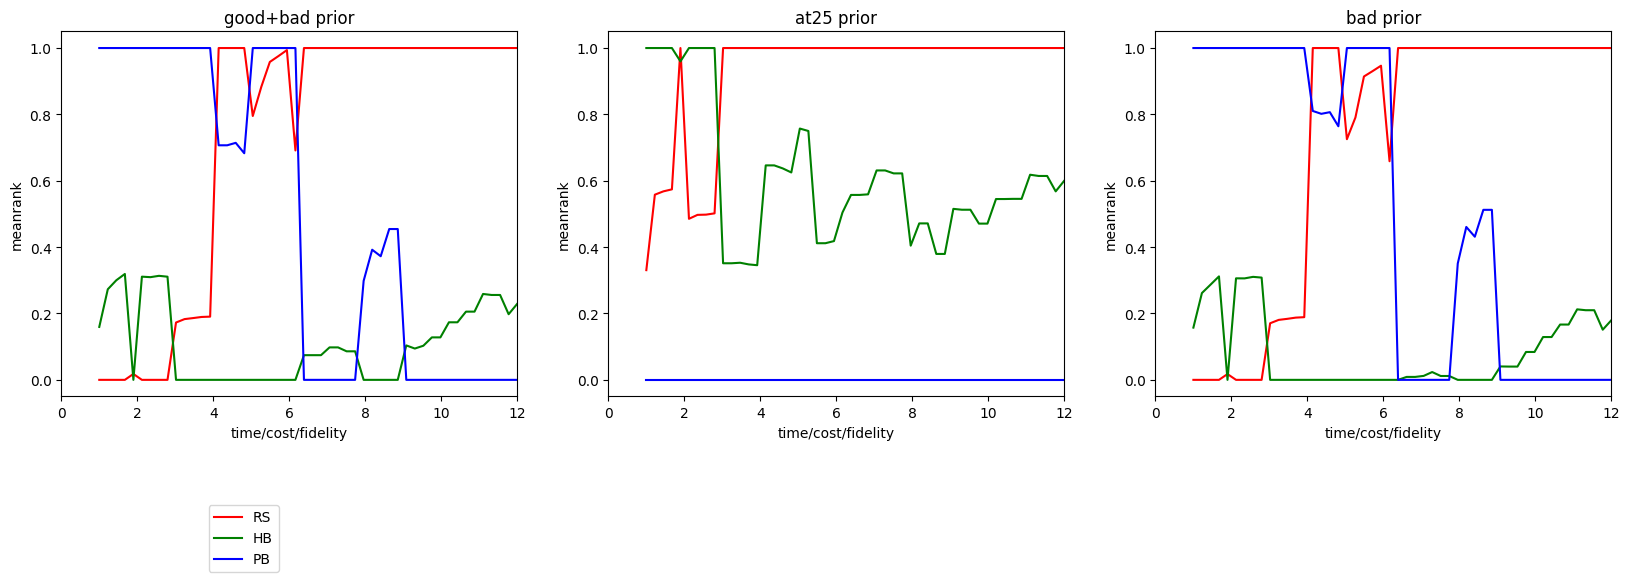

In [11]:
x_data=list(fig5["max_f"])
color_dict={"random_search":"red","hyperband":"green","pb_mutation_dynamic_geometric-default-at-target":"blue","priorband":"blue"}


_, axis = plt.subplots(ncols=len(fig5["priors"]),figsize=(20, 5),sharey=False)
for p_n,prior in enumerate(fig5["priors"]):
    for s_n,system in enumerate(fig5["algorithms"]):
        axis[p_n].errorbar(
            x_data,
            scores[prior][label_dict[system]],
            fmt="-",
            #yerr=((sem[prior][label_dict[system]])/np.sqrt(50)),
            label=label_dict[system],
            color=color_dict[system]
        )
    axis[p_n].set_xlabel("time/cost/fidelity")
    axis[p_n].set_ylabel("meanrank")
    #axis[p_n].semilogy()
    #axis[p_n].set_ylim([1,len(fig5["algorithms"])])
    axis[p_n].set_xlim([0,12])
    axis[p_n].set_title(f"{prior} prior")
legend = plt.legend(bbox_to_anchor=(-2, -0.5), loc='lower center')
plt.subplots_adjust(bottom=0.15)
plt.show()